In [1]:
import sys, os
sys.path.insert(0, os.getcwd() + "/deep-hedging")

from IPython.display import clear_output

import numpy as np
import QuantLib as ql
import tensorflow as tf
from scipy.stats import norm

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
                                            ReduceLROnPlateau
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from stochastic_processes import BlackScholesProcess
from instruments import EuropeanCall
from deep_hedging import Deep_Hedging_Model, Delta_SubModel
from loss_metrics import Entropy
from utilities import train_test_split

%load_ext autoreload

clear_output()
print("\nFinish installing and importing all necessary libraries!")



Finish installing and importing all necessary libraries!


In [2]:
#@title <font color='Blue'>**User Inputs**</font>

# Geometric Brownian Motion.
N = 30 # Number of time steps (in days)

S0 = 100.0 # Stock price at time = 0
sigma = 0.2 # Implied volatility
risk_free = 0.0 # Risk-free rate
dividend = 0.0 # Continuous dividend yield

Ktrain = 1*(10**5) # Size of training sample.
Ktest_ratio = 0.2 # Fraction of training sample as testing sample.
initial_wealth = 0.0
# European call option (short).
strike = S0
payoff_func = lambda x: -np.maximum(x - strike, 0.0)
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N

# Day convention.
day_count = ql.Actual365Fixed() # Actual/Actual (ISDA)

# Proportional transaction cost.
epsilon = 0.0

# Information set (in string)
# Choose from: S, log_S, normalized_log_S (by S0)
information_set = "normalized_log_S"

# Loss function
# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha 
# loss_type = "Entropy" -> loss_param = lambda 

loss_type = "Entropy"
loss_param = 1.0

# Neural network (NN) structure
m = 15 # Number of neurons in each hidden layer.
d = 1# Number of hidden layers (Note including input nor output layer)         

# Neural network training parameters
lr = 1e-2 # Learning rate
batch_size=256 # Batch size
epochs=30 # Number of epochs

# Other parameters
use_batch_norm = False
kernel_initializer = "he_uniform"

activation_dense = "leaky_relu"
activation_output = "sigmoid"
final_period_cost = False

delta_constraint = (0.0, 1.0)
share_stretegy_across_time = False
cost_structure = "constant"

# Other control flags for development purpose.
mc_simulator = "Numpy" # "QuantLib" or "Numpy"


In [3]:
seed = 0 # Random seed. Change to have deterministic outcome.

# Total obs = Training + Testing
nobs = int(Ktrain*(1+Ktest_ratio)) 
		
# Length of one time-step (as fraction of a year).
dt = day_count.yearFraction(calculation_date,calculation_date + 1) 
maturity = N*dt # Maturities (in the unit of a year)

#S0 is init stock price, sigma = Volatility, risk_free = ?, ?,time Day convention
stochastic_process = BlackScholesProcess(s0 = S0, sigma = sigma, risk_free = risk_free, \
                        dividend = dividend, day_count = day_count, seed=seed)

S = stochastic_process.gen_path(maturity, N, nobs)

clear_output()

print("\n\ns0 = " + str(S0))
print("sigma = " + str(sigma))
print("risk_free = " + str(risk_free) + "\n")
print("Number of time steps = " + str(N))
print("Length of each time step = " + "1/365\n")
print("Simulation Done!")



s0 = 100.0
sigma = 0.2
risk_free = 0.0

Number of time steps = 30
Length of each time step = 1/365

Simulation Done!


<IPython.core.display.Javascript object>


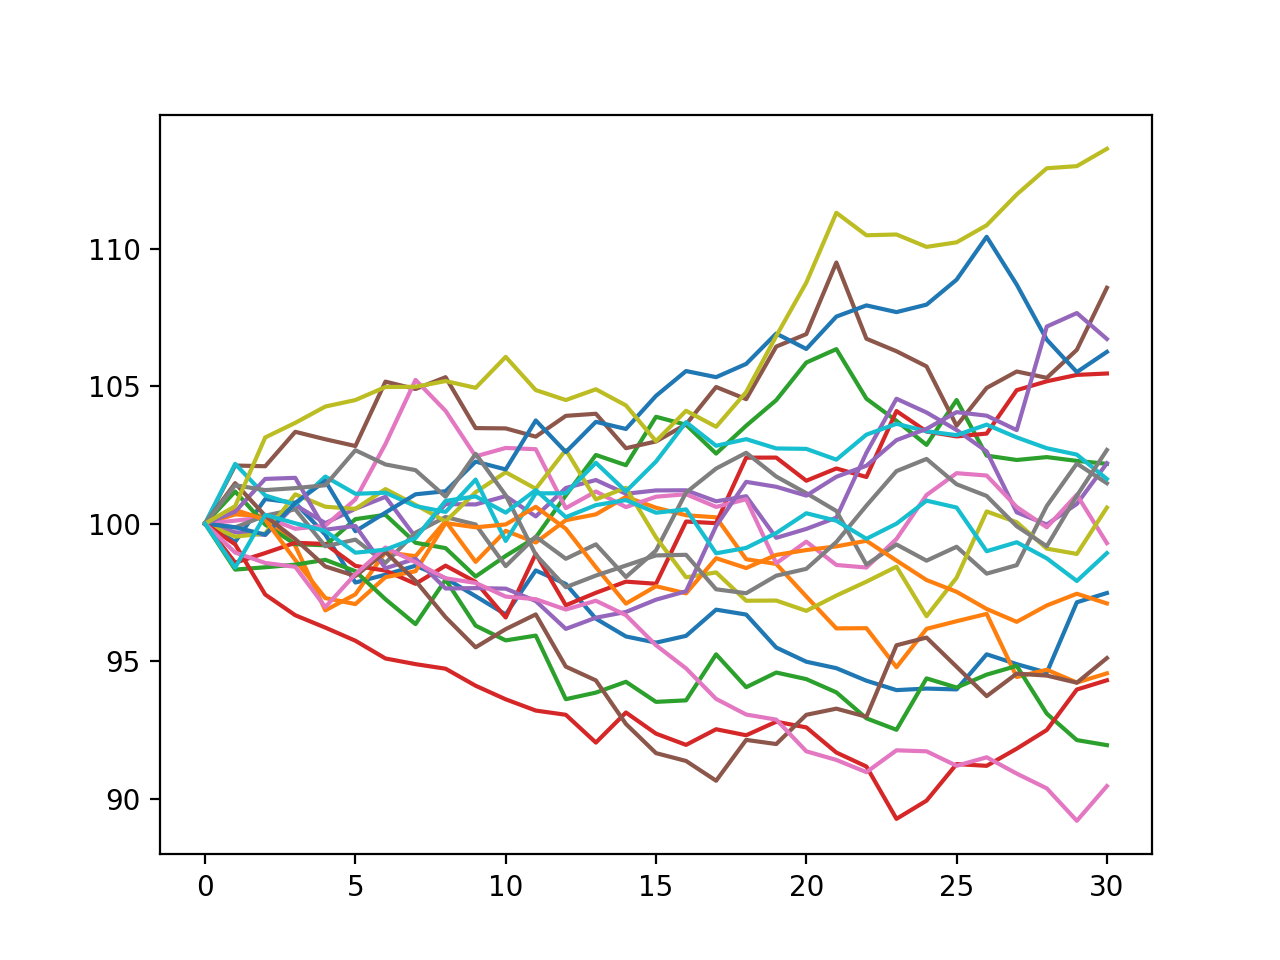

(120000, 31)

In [4]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.plot(S[:20,:].T)

S.shape

In [5]:
#@title <font color='Blue'>**Prepare data to be fed into the deep hedging algorithm.**</font>

payoff_T = payoff_func(S[:,-1]) # Payoff of the call option

trade_set =  np.stack((S),axis=1) # Trading set
if information_set is "S":
  I =  np.stack((S),axis=1) # Information set
elif information_set is "log_S":
  I =  np.stack((np.log(S)),axis=1)
elif information_set is "normalized_log_S":
  I =  np.stack((np.log(S/S0)),axis=1)

#Compute Blackschole delta (needed for No transaction band clamp)
call = EuropeanCall()
delta_BS = np.transpose(call.get_BS_delta(S = np.transpose(trade_set), sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, 
              day_count = day_count, dt = dt))
# Structure of xtrain:
#   1) Trade set: [S]
#   2) Information set: [S]
#   3') BlackSchole delta (for clamp)
#   3) payoff (dim = 1)
x_all = []
for i in range(N+1):
  x_all += [trade_set[i,:,None]]
  if i != N:
    x_all += [I[i,:,None]]
  x_all += [delta_BS[i,:,None]]
x_all += [payoff_T[:,None]]
# Split the entire sample into a training sample and a testing sample.
test_size = int(Ktrain*Ktest_ratio)
[xtrain, xtest] = train_test_split(x_all, test_size=test_size)
[S_train, S_test] = train_test_split([S], test_size=test_size)
[option_payoff_train, option_payoff_test] = \
    train_test_split([x_all[-1]], test_size=test_size)
print("Finish preparing data!")

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_12119/2719828321.py:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if information_set is "S":
/tmp/ipykernel_12119/2719828321.py:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "log_S":
/tmp/ipykernel_12119/2719828321.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "normalized_log_S":


Finish preparing data!


In [6]:
xtrain[0].shape
len(xtrain)

93

In [48]:
#@title <font color='Blue'>**Run the Deep Hedging Algorithm (Recurrent Network)!**</font>
from deep_hedging import Deep_Hedging_Model_MLP_CLAMP
from deep_hedging import Deep_Hedging_Model
optimizer = Adam(learning_rate=lr)
# Setup and compile the model
inputs = tf.keras.Input(shape=(93,))
maxT = 5
model_recurrent = Deep_Hedging_Model(N=N, d=d, m=m, risk_free=risk_free, \
          dt = dt, epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost)

loss = Entropy(model_recurrent.output,None,loss_param)
model_recurrent.add_loss(loss)

model_recurrent.compile(optimizer=optimizer)

model_recurrent.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
prc_0 (InputLayer)              [(None, 1)]          0                                            
_____________________________________________________________________________________

In [49]:

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_recurrent.fit(x=xtrain, batch_size=batch_size, epochs=9, \
          validation_data=[xtest], verbose=1,callbacks=callbacks)

clear_output()
print("Finished running deep hedging algorithm! (Simple Network)")

Epoch 1/9


ValueError: in user code:

    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:204 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_21 expects 62 input(s), but it received 93 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:20' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:21' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:22' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:23' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:24' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:25' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:26' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:27' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:28' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:29' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:30' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:31' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:32' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:33' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:34' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:35' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:36' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:37' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:38' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:39' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:40' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:41' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:42' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:43' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:44' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:45' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:46' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:47' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:48' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:49' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:50' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:51' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:52' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:53' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:54' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:55' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:56' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:57' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:58' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:59' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:60' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:61' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:62' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:63' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:64' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:65' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:66' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:67' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:68' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:69' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:70' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:71' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:72' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:73' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:74' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:75' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:76' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:77' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:78' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:79' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:80' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:81' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:82' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:83' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:84' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:85' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:86' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:87' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:88' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:89' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:90' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:91' shape=(20000, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:92' shape=(20000, 1) dtype=float32>]


In [9]:
#@title <font color='Blue'>**Results: Option Prices**</font>
call = EuropeanCall()

price_BS = call.get_BS_price(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, \
              day_count = day_count, dt = dt)
delta_BS = call.get_BS_delta(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, 
              day_count = day_count, dt = dt)

PnL_BS =  call.get_BS_PnL(S= S_test[0], \
              payoff= payoff_func(S_test[0][:,-1]), delta=delta_BS, \
              dt= dt, risk_free = risk_free, \
              final_period_cost=final_period_cost, epsilon=epsilon, \
              cost_structure = cost_structure )

risk_neutral_price = \
    -option_payoff_test[0].mean()*np.exp(-risk_free*(N*dt))
nn_simple_price = model_recurrent.evaluate(xtest, batch_size=test_size, verbose=0)
print(nn_simple_price)
nn_simple_price = model_recurrent.evaluate(xtest, batch_size=64, verbose=0)
print(nn_simple_price)

print("The Black-Scholes model price is %2.3f." % price_BS[0][0])
print("The Risk Neutral price is %2.3f." % risk_neutral_price)
print("The Deep Hedging (with simple network) price is %2.3f." % nn_simple_price)

try:
  nn_recurrent_price = model_recurrent.evaluate(xtest, batch_size=test_size, verbose=0)
  print("The Deep Hedging (with recurrent network) price is %2.3f." % nn_recurrent_price)
except:
  print("No Recurrent model.")


2.3844611644744873
2.3819117546081543
The Black-Scholes model price is 2.287.
The Risk Neutral price is 2.305.
The Deep Hedging (with simple network) price is 2.382.
The Deep Hedging (with recurrent network) price is 2.384.


In [40]:
#a = model_recurrent.predict(xtest)
xtest[3][xtest[3] == 99.31175309930114]


array([99.3117531])

In [ ]:
#@title <font color='Blue'>**Results: Black-Scholes PnL vs Deep Hedging PnL**</font>
bar1 = PnL_BS #+ price_BS[0][0]
bar2 = model_recurrent(xtest).numpy().squeeze() #+ price_BS[0][0]

# Plot Black-Scholes PnL and Deep Hedging PnL (with BS_price charged on both).
fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Black-Scholes PnL vs Deep Hedging PnL \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_title("Simple Network Structure with epsilon = " + str(epsilon), \
      fontsize=8)
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
          label=["Black-Scholes PnL", "Deep Hedging PnL"])
ax.legend()
plt.show()

In [45]:
option = list()
model = model_recurrent
#for w in range(N):


delta.shape

TensorShape([20000])

<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_12119/3197542753.py:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if information_set is "S":
/tmp/ipykernel_12119/3197542753.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "log_S":
/tmp/ipykernel_12119/3197542753.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "normalized_log_S":


<IPython.core.display.Javascript object>


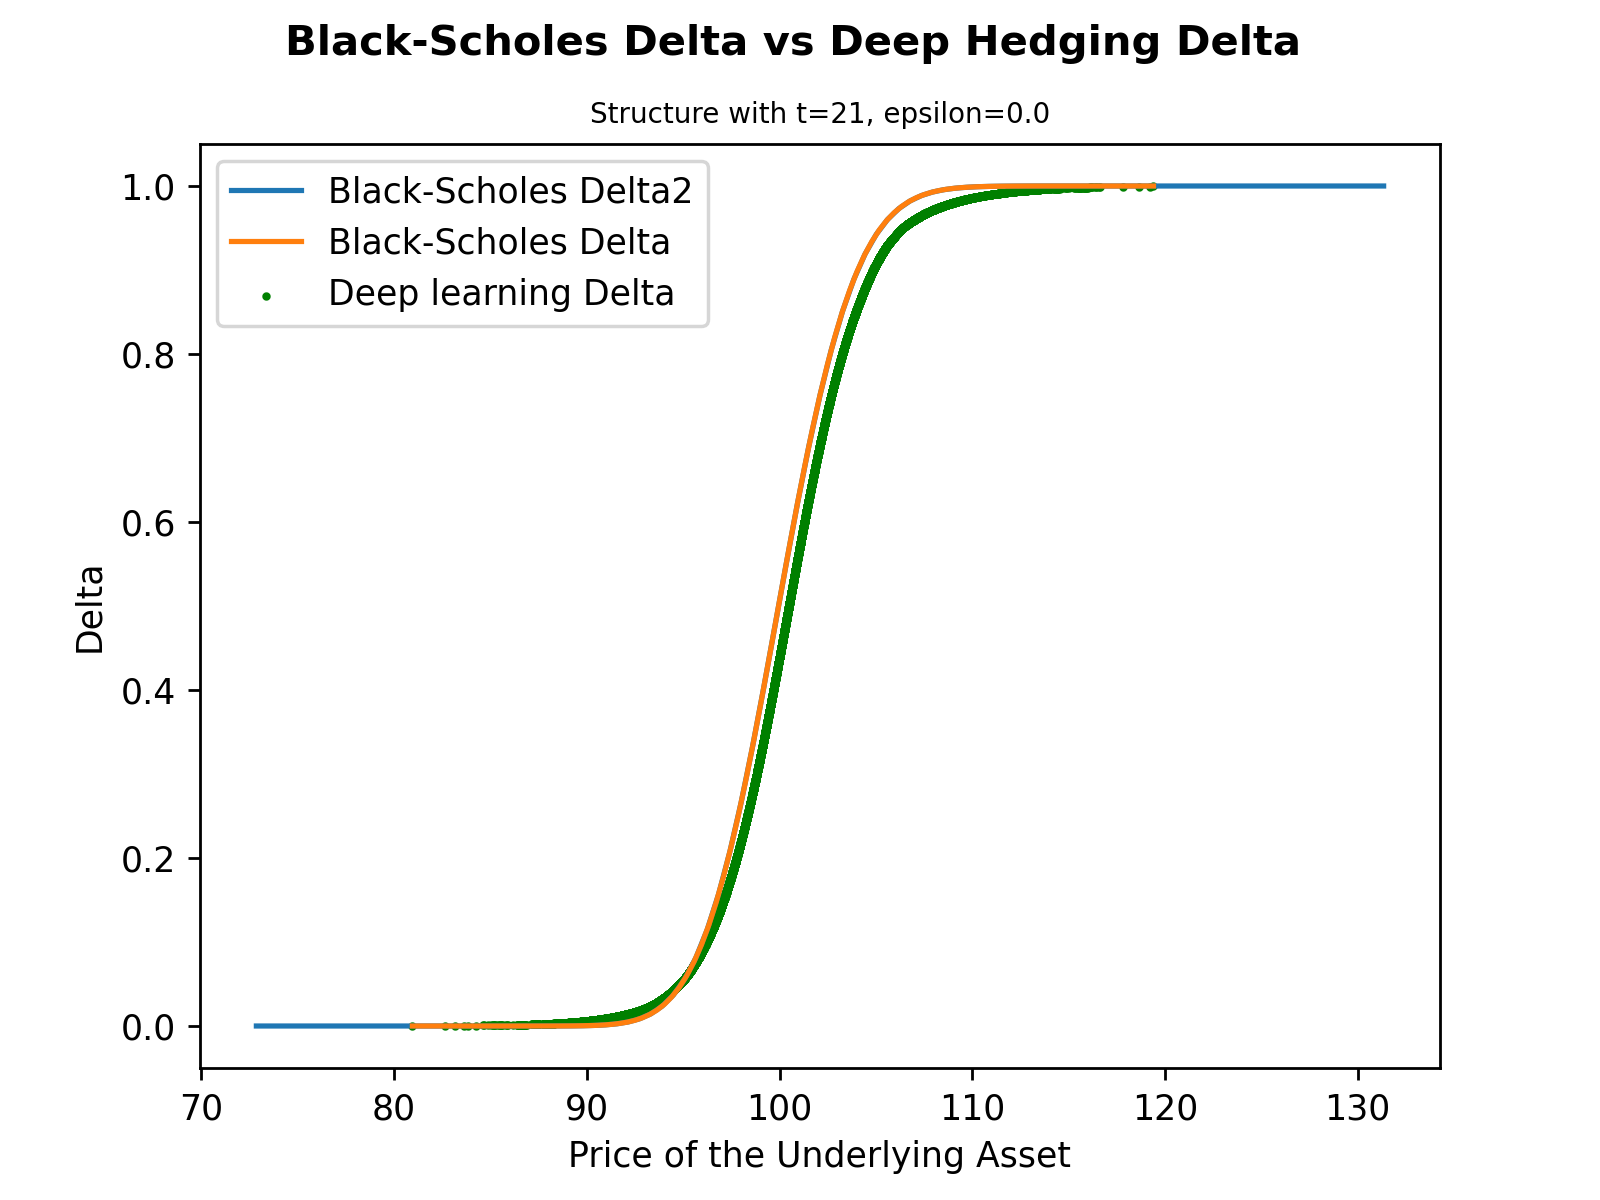

In [44]:
from tensorflow.keras.layers import Input,Concatenate
#@title <font color='Blue'>**Results: Extrapolation**</font>
days_from_today = 21
tau = (N-days_from_today)*dt
batch_size = test_size
min_S = S_test[0][:,days_from_today].min()
max_S = S_test[0][:,days_from_today].max()

S_range = np.linspace(min_S,max_S,101)
S_range2 = np.linspace(min_S*0.9,max_S*1.1,101)

in_sample_range = S_range[np.any([S_range>=min_S, S_range <= max_S], axis=0)]
out_sample_range_low = S_range[S_range<min_S]
out_sample_range_high = S_range[S_range>max_S]

# Attention: Need to transform it to be consistent with the information set.
if information_set is "S":
  I_range =  S_range # Information set
elif information_set is "log_S":
  I_range =  np.log(S_range)
elif information_set is "normalized_log_S":
  I_range =  np.log(S_range/S0)        
    
# Compute Black-Scholes delta for S_range.
# Reference: https://en.wikipedia.org/wiki/Greeks_(finance)
d1 = (np.log(S_range) - np.log(strike) + \
      (risk_free - dividend + (sigma**2)/2)*tau) \
            / (sigma*np.sqrt(tau))  

d12 = (np.log(S_range2) - np.log(strike) + \
      (risk_free - dividend + (sigma**2)/2)*tau) \
            / (sigma*np.sqrt(tau))  

model_delta = norm.cdf(d1)*np.exp(-dividend*tau)
model_delta2 = norm.cdf(d12)*np.exp(-dividend*tau)

intermediate_layer_modelD = Model(inputs=model_recurrent.input,
                                 outputs=model_recurrent.get_layer("delta_%i" %days_from_today).output)

intermediate_layer_modelP = Model(inputs=model_recurrent.input,
                                 outputs=model_recurrent.get_layer("prc_%i" %days_from_today).output)

delta = intermediate_layer_modelD(xtest)
price = intermediate_layer_modelP(xtest)

# Create a plot of Black-Scholes delta against deep hedging delta.
fig_delta = plt.figure(dpi= 125, facecolor='w')
fig_delta.suptitle("Black-Scholes Delta vs Deep Hedging Delta \n", \
      fontweight="bold")
ax_delta = fig_delta.add_subplot()
ax_delta.set_title("Structure with " + \
            "t=" + str(days_from_today) + ", " + \
              "epsilon=" + str(epsilon), \
              fontsize=8)


ax_delta.set_xlabel("Price of the Underlying Asset")
ax_delta.set_ylabel("Delta")
ax_delta.plot(S_range2, model_delta2, label="Black-Scholes Delta2")

ax_delta.plot(S_range, model_delta, label="Black-Scholes Delta")

ax_delta.scatter(price,delta, c="green", s=2, label='Deep learning Delta')

ax_delta.legend()
#plt.show()


In [ ]:
from tensorflow.keras.layers import Input,Concatenate
#@title <font color='Blue'>**Results: Extrapolation**</font>
days_from_today = 15
tau = (N-days_from_today)*dt
batch_size = test_size
min_S = S_test[0][:,days_from_today].min()
max_S = S_test[0][:,days_from_today].max()

S_range = np.linspace(min_S,max_S,101)
S_range2 = np.linspace(min_S*0.9,max_S*1.1,101)

in_sample_range = S_range[np.any([S_range>=min_S, S_range <= max_S], axis=0)]
out_sample_range_low = S_range[S_range<min_S]
out_sample_range_high = S_range[S_range>max_S]

# Attention: Need to transform it to be consistent with the information set.
if information_set is "S":
  I_range =  S_range # Information set
elif information_set is "log_S":
  I_range =  np.log(S_range)
elif information_set is "normalized_log_S":
  I_range =  np.log(S_range/S0)        
    
# Compute Black-Scholes delta for S_range.
# Reference: https://en.wikipedia.org/wiki/Greeks_(finance)
d1 = (np.log(S_range) - np.log(strike) + \
      (risk_free - dividend + (sigma**2)/2)*tau) \
            / (sigma*np.sqrt(tau))  

d12 = (np.log(S_range2) - np.log(strike) + \
      (risk_free - dividend + (sigma**2)/2)*tau) \
            / (sigma*np.sqrt(tau))  

model_delta = norm.cdf(d1)*np.exp(-dividend*tau)
model_delta2 = norm.cdf(d12)*np.exp(-dividend*tau)

intermediate_layer_modelD = Model(inputs=model_recurrent.input,
                                 outputs=model_recurrent.get_layer("delta_%i" %days_from_today).output)

intermediate_layer_modelP = Model(inputs=model_recurrent.input,
                                 outputs=model_recurrent.get_layer("prc_%i" %days_from_today).output)

delta = intermediate_layer_modelD.predict(xtest,batch_size=test_size)
price = intermediate_layer_modelP.predict(xtest,batch_size=test_size)

# Create a plot of Black-Scholes delta against deep hedging delta.
fig_delta = plt.figure(dpi= 125, facecolor='w')
fig_delta.suptitle("Black-Scholes Delta vs Deep Hedging Delta \n", \
      fontweight="bold")
ax_delta = fig_delta.add_subplot()
ax_delta.set_title("Structure with " + \
            "t=" + str(days_from_today) + ", " + \
              "epsilon=" + str(epsilon), \
              fontsize=8)


ax_delta.set_xlabel("Price of the Underlying Asset")
ax_delta.set_ylabel("Delta")
ax_delta.plot(S_range2, model_delta2, label="Black-Scholes Delta2")

ax_delta.plot(S_range, model_delta, label="Black-Scholes Delta")

ax_delta.scatter(price,delta, c="green", s=2, label='Deep learning Delta')

ax_delta.legend()
#plt.show()

In [ ]:
change_wealth = list()
for w in range(N):

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer("wealth_%i" %w).output)
    change_wealth.append(intermediate_layer_model.predict(xtest))
change_wealth

In [ ]:
import pandas as pd
options = pd.DataFrame(np.array(option)[:,:])
#wealths = pd.DataFrame(np.array(change_wealth)[:,:,0])
#fig,ax = plt.subplots()

#ax.plot(options[0],label='options')
#ax.plot(wealths.iloc[:,:20],label='wealth')

#ax.set(ylabel='Wealth',xlabel='Days')

fig,ax = plt.subplots()

#ax.plot(options,label='options')
ax.hist(options.values[0],bins=500)
#ax.plot(wealths,label='wealth')

ax.set(ylabel='Srtaetgy_Leaky',xlabel='Days')


In [ ]:
np.max(options.values[0])

In [ ]:
import pandas as pd
options = pd.DataFrame(np.array(option)[:,:])
#wealths = pd.DataFrame(np.array(change_wealth)[:,:,0])
#fig,ax = plt.subplots()

#ax.plot(options[0],label='options')
#ax.plot(wealths.iloc[:,:20],label='wealth')

#ax.set(ylabel='Wealth',xlabel='Days')

fig,ax = plt.subplots()

#ax.plot(options,label='options')
ax.hist(options.values[0])
#ax.plot(wealths,label='wealth')

ax.set(ylabel='Srtaetgy',xlabel='Days')


In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.plot(np.array(xtrain[6]))
options..shape

In [ ]:
#@title <font color='Blue'>**Results: Extrapolation**</font>
from tensorflow.keras.layers import Input, Concatenate
days_from_today = 27
tau = (N-days_from_today)*dt
  
min_S = S_test[0][:,days_from_today].min()
max_S = S_test[0][:,days_from_today].max()


S_range = np.linspace(min_S*0.8,max_S*1.2,101)

in_sample_range = S_range[np.any([S_range>=min_S, S_range <= max_S], axis=0)]
out_sample_range_low = S_range[S_range<min_S]
out_sample_range_high = S_range[S_range>max_S]

# Attention: Need to transform it to be consistent with the information set.
if information_set is "S":
  I_range =  S_range # Information set
elif information_set is "log_S":
  I_range =  np.log(S_range)
elif information_set is "normalized_log_S":
  I_range =  np.log(S_range/S0)        
    
# Compute Black-Scholes delta for S_range.
# Reference: https://en.wikipedia.org/wiki/Greeks_(finance)
d1 = (np.log(S_range) - np.log(strike) + \
      (risk_free - dividend + (sigma**2)/2)*tau) \
            / (sigma*np.sqrt(tau))  
              
model_delta = norm.cdf(d1)*np.exp(-dividend*tau)

  

#nn_delta = submodel(I_range)
model = model_recurrent
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("delta_%i" %days_from_today).output)

inputs = [Input(1,), Input(1,)]
intermediate_inputs = Concatenate()(inputs)

outputs = model.get_layer("delta_" + str(days_from_today))(intermediate_inputs
                                                           ,model_delta.astype(np.float32))

MODEL = Model(inputs, outputs)

nn_delta = MODEL([I_range,I_range])

# Create a plot of Black-Scholes delta against deep hedging delta.
fig_delta = plt.figure(dpi= 125, facecolor='w')
fig_delta.suptitle("Black-Scholes Delta vs Deep Hedging Delta \n", \
      fontweight="bold")
ax_delta = fig_delta.add_subplot()
ax_delta.set_title("Simple Network Structure with " + \
            "t=" + str(days_from_today) + ", " + \
              "epsilon=" + str(epsilon), \
              fontsize=8)
ax_delta.set_xlabel("Price of the Underlying Asset")
ax_delta.set_ylabel("Delta")
ax_delta.plot(S_range, model_delta, label="Black-Scholes Delta")
ax_delta.scatter(in_sample_range,nn_delta[np.any([S_range>=min_S, S_range <= max_S], axis=0)], c="red", s=2, label="In-Range DH Delta")
ax_delta.scatter(out_sample_range_low,nn_delta[S_range<min_S], c="green", s=2, label="Out-of-Range DH Delta")
ax_delta.scatter(out_sample_range_high,nn_delta[S_range>max_S], c="green", s=2)

ax_delta.legend()
plt.show()

In [ ]:
option

In [ ]:
output = pd.DataFrame()

Var = model_recurrent(xtest).numpy().squeeze()

output['d'] = d
output['m'] = m
output['maxT'] = maxT

output['epsilon'] = epsilon
output['CVar99'] = CVaR(model_recurrent.output, None, 0.99)
output['CVar95'] = CVaR(model_recurrent.output, None, 0.95)
output['CVar90'] = CVaR(model_recurrent.output, None, 0.90)
output['CVar80'] = CVaR(model_recurrent.output, None, 0.80)
output['CVar50'] = CVaR(model_recurrent.output, None, 0.50)

output['Var99'] = np.quartile(Var,0.99)
output['Var95'] = np.quartile(Var, 0.95)
output['Var90'] = np.quartile(Var, 0.90)
output['Var80'] = np.quartile(Var, 0.80)
output['Var50'] = np.quartile(Var,0.50)

output['Mean_PnL'] = np.mean(Var)
output['price'] = nn_simple_price






# Clamp implementation

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Subtract, \
                Lambda, Add, Dot, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import layers
#import keras
from tensorflow.keras.initializers import he_normal, Zeros, he_uniform, TruncatedNormal
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
from loss_metrics import CVaR
from instruments import EuropeanCall
import QuantLib as ql
#from clamp import Clamp
#import torch.nn.functional as fn

intitalizer_dict = { 
    "he_normal": he_normal(),
    "zeros": Zeros(),
    "he_uniform": he_uniform(),
    "truncated_normal": TruncatedNormal()
}

bias_initializer=he_uniform()

class Strategy_Layer(tf.keras.layers.Layer):
    def __init__(self, d = None, m = None, use_batch_norm = None, \
        kernel_initializer = "he_uniform", \
        activation_dense = "relu", activation_output = "linear", 
        delta_constraint = None, day = None):
        super().__init__(name = "delta_" + str(day))
        self.d = d
        self.m = m
        self.use_batch_norm = use_batch_norm
        self.activation_dense = activation_dense
        self.activation_output = activation_output
        self.delta_constraint = delta_constraint
        self.kernel_initializer = kernel_initializer
        
        self.intermediate_dense = [None for _ in range(d)]
        self.intermediate_BN = [None for _ in range(d)]
        
        for i in range(d):
            self.intermediate_dense[i] = Dense(self.m,    
                        kernel_initializer=self.kernel_initializer,
                        bias_initializer=bias_initializer,
                        use_bias=(not self.use_batch_norm))
            if self.use_batch_norm:
                self.intermediate_BN[i] = BatchNormalization(momentum = 0.99, trainable=True)
            
        self.output_dense = Dense(2, 
                      kernel_initializer=self.kernel_initializer,
                      bias_initializer = bias_initializer,
                      use_bias=True)   

    def call(self, input, delta):
        for i in range(self.d):
            if i == 0:
                output = self.intermediate_dense[i](tf.expand_dims(input[:,0], axis=1))
            else:
                output = self.intermediate_dense[i](output)                  
                
            if self.use_batch_norm:
 			    # Batch normalization.
                output = self.intermediate_BN[i](output, training=True)
                
            if self.activation_dense == "leaky_relu":
                output = LeakyReLU()(output)
            else:
                output = Activation(self.activation_dense)(output)
         
        output = self.output_dense(output)
					 
        if self.activation_output == "leaky_relu":
            output = LeakyReLU()(output)
            b_l=  LeakyReLU()(output[..., 0])
            b_u=  LeakyReLU()(output[..., 1])
            min = tf.reshape(delta, shape=(-1,)) - b_l
            max = tf.reshape(delta, shape = (-1,)) + b_u
            condition = tf.math.greater(b_l, b_u)[0]
            output = tf.cond(condition, lambda: (b_l+b_u)/2, lambda: K.clip(input[...,1], min_value=min, max_value=max))

        elif self.activation_output == "sigmoid" or self.activation_output == "tanh" or \
            self.activation_output == "hard_sigmoid":
            # Enforcing hedge constraints (liquidity, costs, ..)
            if self.delta_constraint is not None:
                b_l= Activation(self.activation_output)(output[..., 0])
                b_u= Activation(self.activation_output)(output[..., 1])
                min = tf.reshape(delta, shape=(-1,)) - b_l
                max = tf.reshape(delta, shape=(-1,)) + b_u
                delta_min, delta_max = self.delta_constraint
                condition_delta_l = b_l < delta_min
                condition_delta_u = b_u > delta_max
                min = tf.cond(condition_delta_l, lambda: delta_min, lambda: min)
                max = tf.cond(condition_delta_u, lambda: delta_max, lambda: max)
                #output = Lambda(lambda x : (delta_max-delta_min)*x + delta_min)(output)
                condition = tf.math.greater(b_l, b_u)[0]
                output = tf.cond(condition, lambda: (b_l+b_u)/2, lambda: K.clip(input[...,1], min_value=min, max_value=max))
        
            else:
                b_l= Activation(self.activation_output)(output[..., 0])
                b_u= Activation(self.activation_output)(output[..., 1])
                min = tf.reshape(delta, shape=(-1,)) - b_l
                max = tf.reshape(delta, shape=(-1,)) + b_u
                condition = tf.math.greater(b_l, b_u)[0]
                output = tf.cond(condition, lambda: (b_l+b_u)/2, lambda: K.clip(output[...,1], min_value=min, max_value=max))#input
            
        return output

def Deep_Hedging_Model(N = None, d = None, m = None, delta = None,\
        risk_free = None, dt = None, initial_wealth = 0.0, epsilon = 0.0, \
        final_period_cost = False, strategy_type = None, use_batch_norm = None, \
        kernel_initializer = "he_uniform", \
        activation_dense = "relu", activation_output = "linear", 
        delta_constraint = None, share_stretegy_across_time = False, 
        cost_structure = "proportional"):
    
    
    # State variables.
    prc = Input(shape=(1,), name = "prc_0")
    information_set =Input(shape=(1,), name = "information_set_0") 
    delta_BS = Input(shape=(1,), name="delta_BS_0")
    inputs = [prc, information_set, delta_BS]
    for j in range(N+1):            
        if j < N:
            # Define the inputs for the strategy layers here.
            if strategy_type == "simple":
                helper1 = information_set
            elif strategy_type == "recurrent":
                if j ==0:
                    # Tensorflow hack to deal with the dimension problem.
                    #   Strategy at t = -1 should be 0. 
                    # There is probably a better way but this works.
                    # Constant tensor doesn't work.
                    strategy = Lambda(lambda x: x*0.0)(prc)
                    
                #delta = delta_BS
                helper1 = Concatenate()([information_set,strategy])

            # Determine if the strategy function depends on time t or not.
            if not share_stretegy_across_time:
                strategy_layer = Strategy_Layer(d = d, m = m, \
                         use_batch_norm = use_batch_norm, \
                         kernel_initializer = kernel_initializer, \
                         activation_dense = activation_dense, \
                         activation_output = activation_output, 
                         delta_constraint = delta_constraint, \
                         day = j)
            else:
                if j == 0:
                    # Strategy does not depend on t so there's only a single
                    # layer at t = 0
                    strategy_layer = Strategy_Layer(d = d, m = m, \
                             use_batch_norm = use_batch_norm, \
                             kernel_initializer = kernel_initializer, \
                             activation_dense = activation_dense, \
                             activation_output = activation_output, 
                             delta_constraint = delta_constraint, \
                             day = j)
                             
            strategyhelper = strategy_layer(helper1, delta_BS) #delta_BS[:,j]
            strategyhelper = tf.expand_dims(strategyhelper, axis=1)
            # strategy_-1 is set to 0
            # delta_strategy = strategy_{t+1} - strategy_t
            if j == 0:              
                delta_strategy = strategyhelper
            else:
                delta_strategy = Subtract(name = "diff_strategy_" + str(j))([strategyhelper, strategy])
            
            if cost_structure == "proportional": 
                # Proportional transaction cost
                delta_strategy = delta_strategy
                absolutechanges = Lambda(lambda x : K.abs(x), name = "absolutechanges_" + str(j))(delta_strategy)
                costs = Dot(axes=1)([absolutechanges,prc])
                costs = Lambda(lambda x : epsilon*x, name = "cost_" + str(j))(costs)
            elif cost_structure == "constant":
                # Tensorflow hack..
                costs = Lambda(lambda x : epsilon + x*0.0)(prc)
                    
            if j == 0:
                wealth = Lambda(lambda x : initial_wealth - x, name = "costDot_" + str(j))(costs)
            else:
                wealth = Subtract(name = "costDot_" + str(j))([wealth, costs])
            
            # Wealth for the next period
            # w_{t+1} = w_t + (strategy_t-strategy_{t+1})*prc_t
            #         = w_t - delta_strategy*prc_t
            mult = Dot(axes=1)([delta_strategy, prc])
            wealth = Subtract(name = "wealth_" + str(j))([wealth, mult])

            # Accumulate interest rate for next period.
            FV_factor = np.exp(risk_free*dt)
            wealth = Lambda(lambda x: x*FV_factor)(wealth)
            
            prc = Input(shape=(1,),name = "prc_" + str(j+1))
            information_set = Input(shape=(1,), name = "information_set_" + str(j+1))
            delta_BS = Input(shape=(1,), name = "delta_BS_" + str(j+1))
            strategy = strategyhelper
            
            if j != N - 1:
                inputs += [prc, information_set, delta_BS]
            else:
                inputs += [prc, delta_BS]
        else:
            # The paper assumes no transaction costs for the final period 
            # when the position is liquidated.
            if final_period_cost:
                if cost_structure == "proportional":
                    # Proportional transaction cost
                    absolutechanges = Lambda(lambda x : K.abs(x), name = "absolutechanges_" + str(j))(strategy)
                    costs = Dot(axes=1)([absolutechanges,prc])
                    costs = Lambda(lambda x : epsilon*x, name = "cost_" + str(j))(costs)
                elif cost_structure == "constant":
                    # Tensorflow hack..
                    costs = Lambda(lambda x : epsilon + x*0.0)(prc)

                wealth = Subtract(name = "costDot_" + str(j))([wealth, costs])
            # Wealth for the final period
            # -delta_strategy = strategy_t
            mult = Dot(axes=1)([strategy, prc])
            wealth = Add()([wealth, mult])
                 
            # Add the terminal payoff of any derivatives.
            payoff = Input(shape=(1,), name = "payoff")
            inputs += [payoff]
            
            wealth = Add(name = "wealth_" + str(j))([wealth,payoff])
    return Model(inputs=inputs, outputs=wealth)

def Delta_SubModel(model = None, days_from_today = None, share_stretegy_across_time = False, strategy_type = "simple"):
    print("enter submodel")
    if strategy_type == "simple":
        inputs = model.get_layer("delta_" + str(days_from_today)).input
        intermediate_inputs = inputs
    elif strategy_type == "recurrent":
        inputs = [Input(1,), Input(1,)]
        intermediate_inputs = Concatenate()(inputs)
        
    if not share_stretegy_across_time:
        outputs = model.get_layer("delta_" + str(days_from_today))(intermediate_inputs)
    else:
        outputs = model.get_layer("delta_0")(intermediate_inputs)
        
    return Model(inputs, outputs)
